## WEEK 1

#### 1. Загрузите данные за май 2016 года.

In [1]:
import urllib.request
import pandas as pd
import utils
import geopandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import Polygon

In [2]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv'
filename = '2016_05.csv'

In [3]:
%%time
# скачаем файл за май 2016 года
# данные за остальные месяцы будут обрабатываться по аналогичной схеме
try:
    urllib.request.urlretrieve (url, filename)
    print('Success downloaded %s' % filename)
except Exception as e:
    print('Data load error: ', e)

Success downloaded 2016_05.csv
CPU times: user 6.36 s, sys: 3.68 s, total: 10 s
Wall time: 1min 34s


In [4]:
%%time
# загружаем файл с сырыми данными
data = pd.read_csv(
    filename,
    parse_dates=[1,2]
)
data.head()

CPU times: user 27.5 s, sys: 2.44 s, total: 29.9 s
Wall time: 33.2 s


In [5]:
# библиотека для работы с aws
aws = utils.AWSUtils()

In [6]:
# загружаем файл с координатами регионов (он загружен на Amazon S3)
regions = pd.read_csv('s3://{}/NYTAXI_DATA/regions.csv'.format(aws.s3_bucket_name), sep=';')

In [7]:
# преобразуем координаты в полигоны
geo_regions = geopandas.GeoDataFrame(
    geometry=[
        Polygon([
            (w, n), 
            (e, n), 
            (e, s), 
            (w, s), 
            (w, n)
        ]) for w, e, s, n in zip(
            regions.west, 
            regions.east, 
            regions.south, 
            regions.north
        )
    ]
)

In [8]:
%%time
# определим по координатам id региона
data['pickup_region_id'] = geopandas.tools.sjoin(
    geopandas.GeoDataFrame(
        geometry=geopandas.points_from_xy(data.pickup_longitude, data.pickup_latitude)
    ), 
    geo_regions, 
    how="left",
    op='within'
).iloc[:, 1]

CPU times: user 10min 31s, sys: 8.24 s, total: 10min 39s
Wall time: 10min 38s


In [10]:
%%time
# вычислим продолжительность поездки
data['trip_duration'] = (
    (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'])
    .dt
    .total_seconds()
    .div(60)
    .astype(float)
)

CPU times: user 6.52 s, sys: 323 ms, total: 6.84 s
Wall time: 4.47 s


In [11]:
%%time
# отбросим минуты и секунды во времени начала поездки
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor('h')

CPU times: user 203 ms, sys: 115 µs, total: 203 ms
Wall time: 153 ms


#### 2. Проведите фильтрацию: удалите поездки с
    нулевой длительностью
    нулевым количеством пассажиров
    нулевым расстоянием поездки по счётчику
    координатами начала, не попадающими в прямоугольник Нью-Йорка
Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково.

In [12]:
%%time
# фильтр по поездкам
data.drop(
    data[
        (data['passenger_count']==0)
        | (data['trip_distance']==0) 
        | (data['trip_duration']==0)
        | (data['pickup_region_id'].isna())
    ].index,
    inplace=True
)

CPU times: user 2.74 s, sys: 2.17 s, total: 4.91 s
Wall time: 2.81 s


#### 3. Агрегируйте данные за май 2016 года по часам и областям 
(можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

In [14]:
%%time
# агрегируем данные по количеству пассажиров,
# а так же по дополнительным полям, которые пригодятся на 6 неделе
aggregated_data = data.groupby(
    ['tpep_pickup_datetime', 'pickup_region_id'], as_index=False
).agg(
    {
        'passenger_count': ['sum', 'mean'],
        'trip_distance': ['mean'],
        'total_amount': ['mean'],
        'trip_duration': ['mean']
    }
)

aggregated_data.columns = [
    'pickup_datetime', 
    'pickup_region_id', 
    'passenger_count_sum', 
    'passenger_count_mean', 
    'trip_distance_mean',
    'total_amount_mean',
    'trip_duration_mean'
]

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.31 s


In [17]:
%%time
# сохраним агрегированные данные в БД, для следующих заданий
datautils = utils.TaxiDataUtils()
aws.sql_function_execute(datautils.create_aggregateddata_table)
aggregated_data.to_sql(
    'taxi_aggregateddata', 
    con=aws.get_sqlalchemy_engine(), 
    schema='mldb', 
    if_exists='append', 
    index=False
)

Table taxi_aggregateddata created
CPU times: user 2.94 s, sys: 31.9 ms, total: 2.98 s
Wall time: 4.8 s


#### 4. Выведите первые строки полученной таблицы 
с указанием времени, идентификатора зоны и количества поездок.

In [20]:
try:
    conn = aws.connect_to_db()
    data_count = pd.read_sql(
        'SELECT \
            pickup_datetime, pickup_region_id, passenger_count_sum \
         FROM \
            mldb.taxi_aggregateddata \
         WHERE \
            MONTH(pickup_datetime) = 5 AND YEAR(pickup_datetime) = 2016',
        conn, 
        parse_dates=[0]
    )
finally:
    conn.close()

data_count.head()

,pickup_datetime,pickup_region_id,passenger_count_sum
0,2016-05-01,1014,5
1,2016-05-01,1016,1
2,2016-05-01,1028,3
3,2016-05-01,1029,1
4,2016-05-01,1032,4


#### 5. Постройте график количества поездок 
жёлтого такси из ячейки, содержащей Empire State Building.

In [22]:
%%time
# сохраним коодинаты полигонов в БД, для дальнейшей работы
regions.rename(columns={'region': 'region_id'}, inplace=True)
aws.sql_function_execute(datautils.create_regions_table)
regions.to_sql(
    'taxi_regions', 
    con=aws.get_sqlalchemy_engine(), 
    schema='mldb', 
    if_exists='append', 
    index=False
)
aws.sql_function_execute(datautils.set_geo_polygons)

Table taxi_regions created
CPU times: user 57.1 ms, sys: 4 ms, total: 61.1 ms
Wall time: 233 ms


In [24]:
# координаты Empire State Building
esb_location = geopandas.tools.geocode('Empire State Building')

In [50]:
%%time
try:
    conn = aws.connect_to_db()
    esb_data = pd.read_sql(
        'SELECT \
            ad.pickup_datetime, ad.passenger_count_sum \
         FROM \
            taxi_aggregateddata ad \
            LEFT JOIN taxi_regions r on ad.pickup_region_id=r.region_id \
         WHERE \
            ST_CONTAINS( \
                r.region_poly, \
                POINT({x}, {y}) \
            )'.format(
            x=esb_location.geometry.x[0], 
            y=esb_location.geometry.y[0]
        ),
        conn,
        parse_dates=['pickup_datetime'],
        index_col=['pickup_datetime']
    )
finally:
    conn.close()

CPU times: user 17.6 ms, sys: 78 µs, total: 17.7 ms
Wall time: 59.3 ms


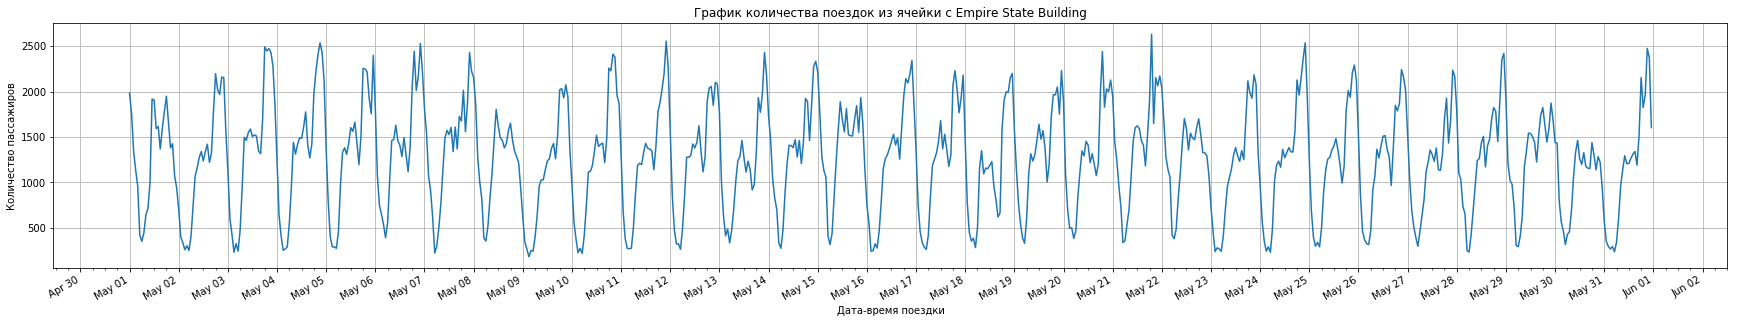

In [117]:
fig, ax = plt.subplots(figsize=(30, 5))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.plot(esb_data.passenger_count_sum)
ax.set_ylabel("Количество пассажиров")
ax.set_xlabel("Дата-время поездки")
ax.set_title("График количества поездок из ячейки с Empire State Building")
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.HourLocator((0,6,12,18)))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
fig.autofmt_xdate()

plt.show()

#### 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, 
для которых не было совершено ни одной поездки.

In [207]:
%%time
# посчитаем это с помощью преобразования полей с id региона в столбцы

fill_values = {
    'pickup_datetime': pd.to_datetime('05/01/2016'), 
    'passenger_count_sum': 0 
}

data_pivot = (
    regions
    .set_index('region_id')
    .join(other=data_count.set_index('pickup_region_id'))
    .reset_index()
    .fillna(value=fill_values)
    .pivot_table('passenger_count_sum', 'pickup_datetime', 'index', fill_value=0)
)

print(data_pivot.shape)

(744, 2500)
CPU times: user 1.21 s, sys: 15.2 ms, total: 1.22 s
Wall time: 1.02 s


In [209]:
res = 0
for i in range(1, 2500+1):
    res += data_pivot[data_pivot[i]==0].shape[0]
print('empty hour-cell count: {}'.format(res))

empty hour-cell count: 1718238
